# Periodicity Analysis

To verify whether periodicity in the Covid-19 data from the Uk is a product of the reporting process, or due to some phenomenan in the underlying processes.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

from phe_api import retrieve_data

In [2]:
# Read in data

df = pd.DataFrame(retrieve_data())
df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")
df.sort_values(by="date", inplace=True)
print(df.columns.values)

['date' 'areaCode' 'newCasesByPublishDate' 'newCasesBySpecimenDate'
 'newDeaths28DaysByDeathDate' 'newDeaths28DaysByPublishDate']


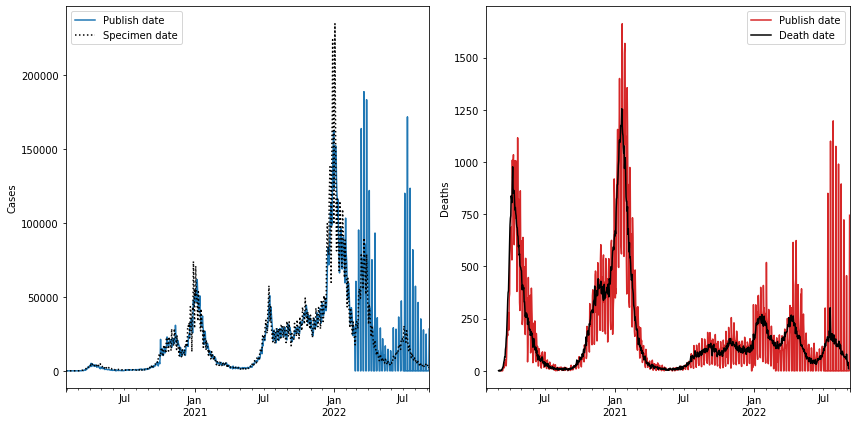

In [3]:
plt.rcParams['font.size'] = '16'
fig, axs = plt.subplots(1, 2, figsize=(12,6))

plot1 = df.plot.line('date', 'newCasesByPublishDate', ax=axs[0], color='tab:blue', label='Publish date')
plot1 = df.plot.line('date', 'newCasesBySpecimenDate', ax=axs[0], color='black', linestyle=':', label = 'Specimen date')
axs[0].set_xlabel(''); axs[0].set_ylabel('Cases')

plot2 = df.plot.line('date', 'newDeaths28DaysByPublishDate', ax=axs[1], color='tab:red', label = 'Publish date')
plot2 = df.plot.line('date', 'newDeaths28DaysByDeathDate', ax=axs[1], color='black', label = 'Death date')
axs[1].set_xlabel(''); axs[1].set_ylabel('Deaths')

fig.tight_layout()
# plt.savefig(f"../images/uk_phe_data/new_cases_and_deaths.png")


In [18]:
# Plot Fourier components of case data

# from scipy import fftpack

def rel_reporting_calc(df, column_list):
    """Adds columns to dataframe giving weekday information,
    as well as the relative reporting factor."""
    df['Day_Index'] = df['date'].apply(lambda x: x.weekday())
    df['Weekday'] = df['date'].apply(lambda x: x.day_name())
    for column in column_list:
        mean = df[column].rolling(7).mean()
        df['Dif_' + column] = df[column] / mean
    return df       

def fourier_transform(df, column, compute_psd = False):
    data = df[column].fillna(0).values
    data_fft = sp.fftpack.fft(data)
    data_psd = np.abs(data_fft) ** 2  # Power Spectral density

    fftfreq = sp.fftpack.fftfreq(len(data_fft), 1/7)  # Frequency units in weeks
    return (data_psd, fftfreq) if compute_psd else (data_fft, fftfreq)

def plot_fft(data, freq, ax, color, label, alpha = 1):
    i = freq > 0  # Remove negative frequencies
    ax.plot(freq[i], 10 * np.log10(data[i]), color=color, alpha=alpha, label=label)
    y_lim = ax.get_ylim()
    ax.vlines([(n+1) for n in range(3)], y_lim[0], y_lim[1],
              colors='gray', linestyles='dashed', alpha=0.6)
    # ax.axvspan(0, 0.9, facecolor='gray', alpha=0.3)
    ax.set_xlabel('Frequency (1/week)')
    ax.set_ylabel('PSD (dB)')
    ax.legend(loc=3); ax.set_xlim((0, max(freq[i])))


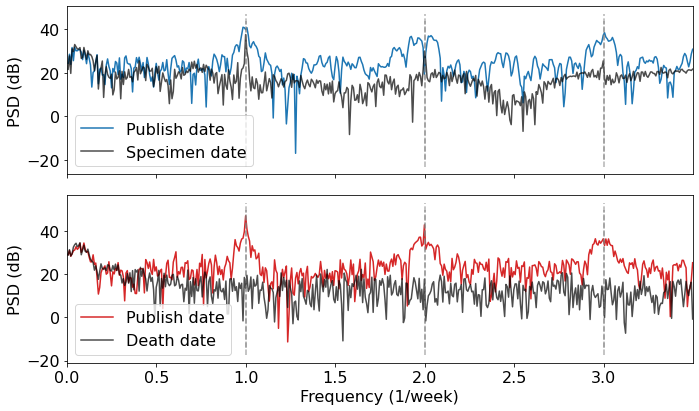

In [21]:
plt.rcParams['font.size'] = '16'
fig, axs = plt.subplots(2, 1, figsize=(10,6))

df["Days"] = df["date"].apply(lambda date: (date - min(df["date"])).days)
df = rel_reporting_calc(df, ['newCasesByPublishDate', 'newCasesBySpecimenDate',
                             'newDeaths28DaysByDeathDate', 'newDeaths28DaysByPublishDate'])

case_fft_pub, case_freq_pub = fourier_transform(df, column='Dif_newCasesByPublishDate', compute_psd=True)
plot_fft(case_fft_pub, case_freq_pub, ax=axs[0], color='tab:blue', label="Publish date")
case_fft_spec, case_freq_spec = fourier_transform(df, column='Dif_newCasesBySpecimenDate', compute_psd=True)
plot_fft(case_fft_spec, case_freq_spec, ax=axs[0], color='black', alpha=0.7, label="Specimen date")
axs[0].set_xlabel(''); axs[0].set_xticklabels([])

death_fft_pub, death_freq_pub = fourier_transform(df, column='Dif_newDeaths28DaysByPublishDate', compute_psd=True)
plot_fft(death_fft_pub, death_freq_pub, ax=axs[1], color='tab:red', label="Publish date")
death_fft_cert, death_freq_cert = fourier_transform(df, column='Dif_newDeaths28DaysByDeathDate', compute_psd=True)
plot_fft(death_fft_cert, death_freq_cert, ax=axs[1], color='black', alpha=0.7, label="Death date")

fig.tight_layout()
plt.savefig(f"../images/data_trends/daily_fft_casea_deaths.png")
